In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

In [2]:
IMG_BASE = '../../content/images/boardgames/'

games = pd.read_pickle('data/boardgame_clean.pkl')

In [3]:
MIN_USERS_TO_COUNT = 30
mask_enough_ratings = (games['users_rated'] > MIN_USERS_TO_COUNT)

moment_subset = games.loc[mask_enough_ratings, 'average_rating']

pop_mean = moment_subset.mean()
pop_var = moment_subset.var()

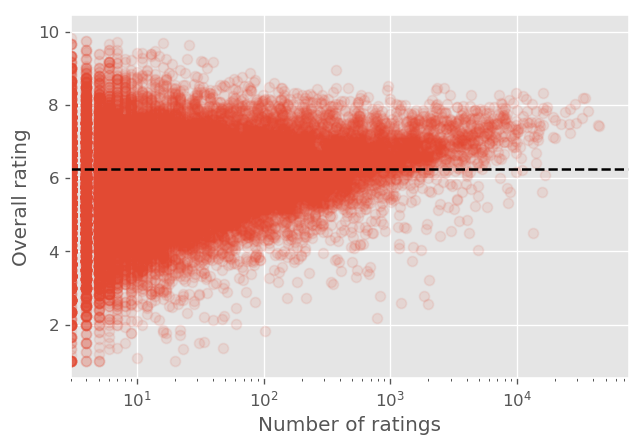

In [4]:
plt.figure(dpi=120)

plt.semilogx(games['users_rated'], games['average_rating'], marker='o', linestyle='None', alpha=0.1)

plt.xlim(3,)
plt.xlabel('Number of ratings')
plt.ylabel('Overall rating')
plt.gca().axhline(pop_mean, c='k', linestyle='--');

In [5]:
from sklearn.linear_model import LassoCV, LogisticRegression

lasso = LassoCV()
X = np.log(games.loc[mask_enough_ratings, 'users_rated'])
y = games.loc[mask_enough_ratings, 'average_rating']
targets = np.log(y/(10-y))

In [6]:
lasso.fit(X.values.reshape(-1,1), targets)
lasso.score(X.values.reshape(-1,1), targets)

0.08777178791921247

In [7]:
lasso.coef_, lasso.intercept_

(array([0.08603769]), 0.0922463773336627)

In [8]:
def average_rating(num_ratings, lasso_model=lasso):
    coefs, intercept = lasso_model.coef_, lasso_model.intercept_
    args = coefs*np.log(num_ratings) + intercept
    return 10/(1+np.exp(-args))

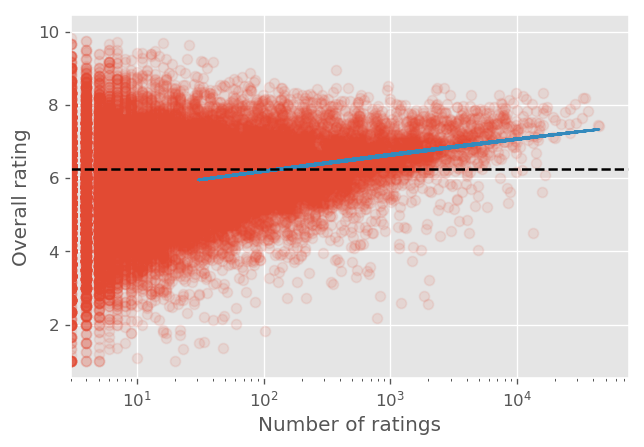

In [9]:
plt.figure(dpi=120)

plt.semilogx(games['users_rated'], games['average_rating'], marker='o', linestyle='None', alpha=0.1)

plt.semilogx(games.loc[mask_enough_ratings, 'users_rated'], 
             average_rating(games.loc[mask_enough_ratings, 'users_rated']))
plt.xlim(3,)
plt.xlabel('Number of ratings')
plt.ylabel('Overall rating')
plt.gca().axhline(pop_mean, c='k', linestyle='--');

In [10]:
def method_of_moments(average_ratings, variance_ratings, num_ratings, lasso_model=lasso):
    mean = average_rating(num_ratings, lasso_model)

    pop_variance = (average_ratings - mean).var()
    var_error = variance_ratings/num_ratings
    
    interpolate = pop_variance / (pop_variance + var_error)
    
    return interpolate*average_ratings + (1-interpolate)*mean

In [11]:
games['shrinkage'] = method_of_moments(games['average_rating'], games['rating_stddev']**2, games['users_rated'])

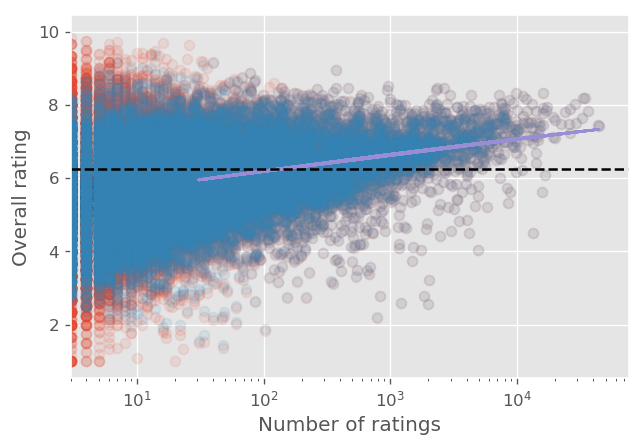

In [12]:
plt.figure(dpi=120)

plt.semilogx(games['users_rated'], games['average_rating'], marker='o', linestyle='None', alpha=0.1)
plt.semilogx(games['users_rated'], games['shrinkage'], marker='o', linestyle='None', alpha=0.1)

plt.semilogx(games.loc[mask_enough_ratings, 'users_rated'], 
             average_rating(games.loc[mask_enough_ratings, 'users_rated']))
plt.xlim(3,)
plt.xlabel('Number of ratings')
plt.ylabel('Overall rating')
plt.gca().axhline(pop_mean, c='k', linestyle='--');

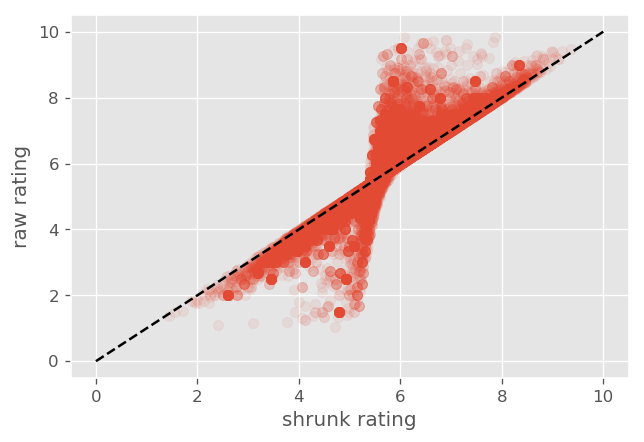

In [13]:
plt.figure(dpi=120)
plt.scatter(games['shrinkage'], games['average_rating'], alpha=0.08)
plt.plot([0,10], [0, 10], 'k--')
plt.ylabel('raw rating')
plt.xlabel('shrunk rating');